ASSIGNMENT 1 - Daniele Gotti

INTRODUCTION

This notebook contains the code for the spam detector, the analysis with the plots, and the final model, which was tested on the final *test.csv* dataset and exported as prediction.npy.

For the code, I followed as closely as possible the exercises presented during class, particularly *Practical1.ipynb* (the code is very similar), but I reorganized it in a more engineering-oriented manner, encapsulating operations into functions to allow for easy modification of the MLP parameters during the analysis and optimal model selection.

PART 1 - IMPLEMENTING AND TRAINING A MLP

In [3]:
# import all the libraries
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [4]:
# read from  the csv
df = pd.read_csv("train.csv")
print(tabulate(df.head(), headers='keys', tablefmt='psql'))
print("Total number of rows:", len(df))

+----+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+----------+
|    |   Unnamed: 0 |   feature_1 |   feature_2 |   feature_3 |   feature_4 |   feature_5 |   feature_6 |   feature_7 |  

In [5]:
# a helper function to prepare the data
def prepare_data(filepath, test_size=0.2, random_state=42):
  df = pd.read_csv(filepath)

  # separate the feature columns from the target column (for convenience)
  X = df.drop(columns=['target']).values
  y = df['target'].values

  # train/validation split
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=test_size, random_state=random_state, stratify=y
  )

  # apply StandardScalar since features are of different scales (fit on train, transform both)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)

  return X_train, X_val, y_train, y_val


In [6]:
# define a pytorch dataset
class EmailDataset(Dataset):
  def __init__(self, X, y):

    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  # a function that we must implement, and it returns the length of the dataset
  def __len__(self):
    return len(self.X)

  # a function that we must implement. It fetches the elements of the dataset
  def __getitem__(self, idx):
    # it will return the tuple (X, y) for a given index idx
    return self.X[idx], self.y[idx]


I decided to split the dataset using cross-validation fixed at an 80–20 ratio, which will remain unchanged throughout the analysis.

In [7]:
# call the helper function to get the train and validation splits
X_train, X_val, y_train, y_val = prepare_data(
    filepath="train.csv",
    test_size=0.2,
    random_state=42
)

# check the shapes of these matrices
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# notice that now the features are normalized
print(X_train[0:3])

(2944, 58)
(2944,)
(736, 58)
(736,)
[[-0.86154154 -0.34251046 -0.16595877  1.88810284 -0.05040964 -0.47638316
  -0.34056862 -0.28954072 -0.28363998 -0.31842106 -0.4185295  -0.29593884
  -0.64256126 -0.3114586  -0.19817763 -0.19067766 -0.29134683 -0.32362624
  -0.35398319  0.43889008 -0.1884636  -0.68550686 -0.11962478 -0.29748586
  -0.24290115 -0.33061653 -0.29775286 -0.22632663 -0.23250251 -0.1829449
  -0.22401164 -0.15970488 -0.1454004  -0.16228588 -0.14649266 -0.1944359
  -0.22968329 -0.31744215 -0.05890446  2.75796038 -0.18672853 -0.11390496
  -0.18885534 -0.19780959 -0.14866888  0.83158463 -0.20252747 -0.06545209
  -0.0922204   0.75510638 -0.47745997 -0.14056075 -0.03330412 -0.29269918
  -0.09748456 -0.12702279 -0.23218172 -0.49234324]
 [ 0.23110636  0.09798227 -0.16595877 -0.1333882  -0.05040964  2.1872637
   1.1285673  -0.28954072 -0.28363998 -0.07778955 -0.16141819  0.03699639
   0.03758457  0.84411875  0.032742   -0.19067766 -0.29134683  0.32113892
  -0.35398319  1.49519133  0

In [8]:
# define the MLP classifier
class EmailClassifier(nn.Module):

  def __init__(self, input_dim, hidden_layers, output_dim, activation_fn=nn.ReLU, dropout_prob=0.0):
    super().__init__()  # initialize the parent class

    # create a list to hold all the layers
    layers = []

    # the first hidden layer takes input of the specified dimension
    in_features = input_dim

    # iterate through all hidden layer sizes
    for out_features in hidden_layers:
      # add a fully connected (linear) layer
      layers.append(nn.Linear(in_features, out_features))
      # add the activation function
      layers.append(activation_fn())
      # add a dropout layer if needed
      if dropout_prob > 0.0:
        layers.append(nn.Dropout(p=dropout_prob))
      # the next layer input size is the current layer output size
      in_features = out_features

    # finally, add the output layer
    layers.append(nn.Linear(in_features, output_dim))

    # passe the data through all modules in order
    self.network = nn.Sequential(*layers)

  # here we will specify the forward pass
  def forward(self, x):
    x = self.network(x)
    return x

In [9]:
# a helper function to train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs, lr, weight_decay):
    # check if GPU or not
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # move the model to the gpu
    model = model.to(device)

    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # lists for plotting
    train_loss_ar = []
    train_acc_ar = []
    val_loss_ar = []
    val_acc_ar = []

    # beginning of training and validation loop
    for epoch in range(num_epochs):
      # ----Train----
      model.train() # put the model in train mode
      train_loss = 0.0
      correct = 0
      total = 0

      # draw mini-batches with the help of the dataloader
      for X_batch, y_batch in train_dataloader:
        # send the data to the device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad() # zero the gradients before every backprop
        outputs = model(X_batch) # forward pass to get outputs
        loss = criterion(outputs, y_batch) # compute the loss
        loss.backward() # compute the gradients and backprop
        optimizer.step() # perform the weight updates

        # record the train loss and train accuracy
        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, dim=1) # get the arg max prediction
        total += y_batch.size(0) # total number of samples
        # check if the predictions are correct or not
        correct += (predicted == y_batch).sum().item() # item is used to convert it to numpy numbers

      # calculate average loss and accuracy after one epoch
      train_loss = train_loss / total
      train_acc = correct / total
      train_loss_ar.append(train_loss)
      train_acc_ar.append(train_acc)

      # ----- Validation ------
      # check the validation loss and accuracy after every epoch
      model.eval() # put the model in eval mode during evaluation
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad(): # this means no need to compute gradient, done to free memory
        for X_batch, y_batch in val_dataloader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)

          val_loss += loss.item() * X_batch.size(0)
          val_total += y_batch.size(0)
          _, predicted = torch.max(outputs, 1)
          val_correct += (predicted == y_batch).sum().item()

      val_loss = val_loss / val_total
      val_acc = val_correct / val_total
      val_loss_ar.append(val_loss)
      val_acc_ar.append(val_acc)

      # print the stats
      print(f"Epoch [{epoch + 1}/{num_epochs}] "
            f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | "
            f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

    return train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar

In [10]:
# a helper function to plot the results
def plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar):
    epochs = np.arange(len(val_acc_ar)) + 1

    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 5))

    # visualize the train and validation accuracy in a plot
    train_acc = np.array(train_acc_ar) * 100.
    val_acc = np.array(val_acc_ar) * 100.
    plot1.plot(epochs, train_acc, label='train acc', color='red')
    plot1.plot(epochs, val_acc, label='val acc', color='green')
    plot1.set_title('Accuracy plot')
    plot1.set_xlabel('epochs')
    plot1.set_ylabel('accuracy (%)')
    plot1.set_xticks(epochs)
    plot1.legend()

    # visualize the train and validation loss in a plot
    train_loss = np.array(train_loss_ar)
    val_loss = np.array(val_loss_ar)
    plot2.plot(epochs, train_loss, label='train loss', color='red')
    plot2.plot(epochs, val_loss, label='val loss', color='green')
    plot2.set_title('Loss plot')
    plot2.set_xlabel('epochs')
    plot2.set_ylabel('loss')
    plot2.set_xticks(epochs)
    plot2.legend()

    plt.show()

PART 2 - FINDING THE BEST CONFIGURATION

Experiment 1

Purpose:

To establish a baseline performance. A standard configuration is used (medium-sized architecture, common hyperparameters, no regularization) to obtain a reference point for comparison with all subsequent experiments.

Setup:

hidden_layers = [64, 32], batch_size = 32, lr = 0.001, weight_decay = 0.0, dropout = 0.0, epochs = 20, activation_fn = nn.ReLU.

Expectation:

The model is expected to learn well on the training data.

EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.4094 | Train accuracy: 0.8543 | Val loss: 0.2181 | Val accuracy: 0.9307
Epoch [2/20] Train loss: 0.2185 | Train accuracy: 0.9263 | Val loss: 0.1786 | Val accuracy: 0.9429
Epoch [3/20] Train loss: 0.1863 | Train accuracy: 0.9334 | Val loss: 0.1614 | Val accuracy: 0.9402
Epoch [4/20] Train loss: 0.1672 | Train accuracy: 0.9416 | Val loss: 0.1502 | Val accuracy: 0.9484
Epoch [5/20] Train loss: 0.1553 | Train accuracy: 0.9453 | Val loss: 0.1492 | Val accuracy: 0.9402
Epoch [6/20] Train loss: 0.1454 | Train accuracy: 0.9474 | Val loss: 0.1343 | Val accuracy: 0.9524
Epoch [7/20] Train loss: 0.1371 | Train accuracy: 0.9504 | Val loss: 0.1316 | Val accuracy: 0.9497
Epoch [8/20] Train loss: 0.12

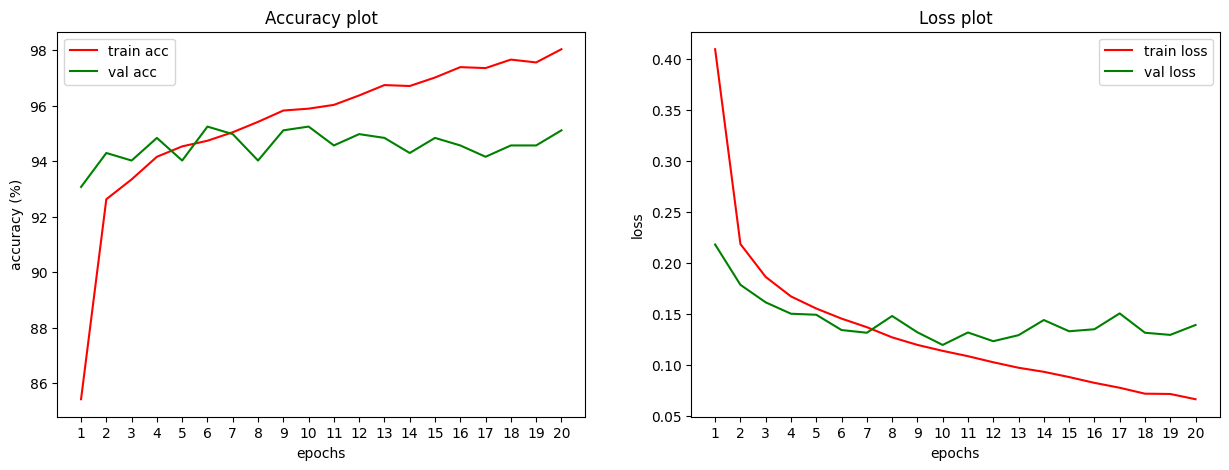

In [11]:
# Experiment 1

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_1 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.0
)
print(model_1)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_1,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

This model is overfitted. The training accuracy keeps increasing up to 98%, while the validation accuracy plateaus around 95%. The validation loss confirms this trend: it reaches its minimum at epoch 9 and subsequently starts to rise.

Experiment 2

Purpose:

To verify whether the baseline model is too complex for the given problem. A simpler network architecture is expected to reduce the risk of overfitting.

Setup:

hidden_layers = [32] (reduced from [64, 32]); all other hyperparameters remain unchanged.

Expectation:

The training and validation curves are expected to be much closer, indicating reduced overfitting. If the validation accuracy remains high, the simpler model is sufficient. If the validation accuracy drops significantly, the model is too simple and suffers from underfitting.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.4952 | Train accuracy: 0.8064 | Val loss: 0.3086 | Val accuracy: 0.9130
Epoch [2/20] Train loss: 0.2708 | Train accuracy: 0.9141 | Val loss: 0.2190 | Val accuracy: 0.9389
Epoch [3/20] Train loss: 0.2225 | Train accuracy: 0.9276 | Val loss: 0.1926 | Val accuracy: 0.9402
Epoch [4/20] Train loss: 0.2016 | Train accuracy: 0.9293 | Val loss: 0.1771 | Val accuracy: 0.9334
Epoch [5/20] Train loss: 0.1882 | Train accuracy: 0.9341 | Val loss: 0.1664 | Val accuracy: 0.9484
Epoch [6/20] Train loss: 0.1795 | Train accuracy: 0.9344 | Val loss: 0.1592 | Val accuracy: 0.9497
Epoch [7/20] Train loss: 0.1715 | Train accuracy: 0.9389 | Val loss: 0.1529 | Val accuracy: 0.9511
Epoch [8/20] Train loss: 0.1662 | Train accuracy: 0.9419 | Val loss: 0.1475 | Val accuracy: 0.9538
Epoch 

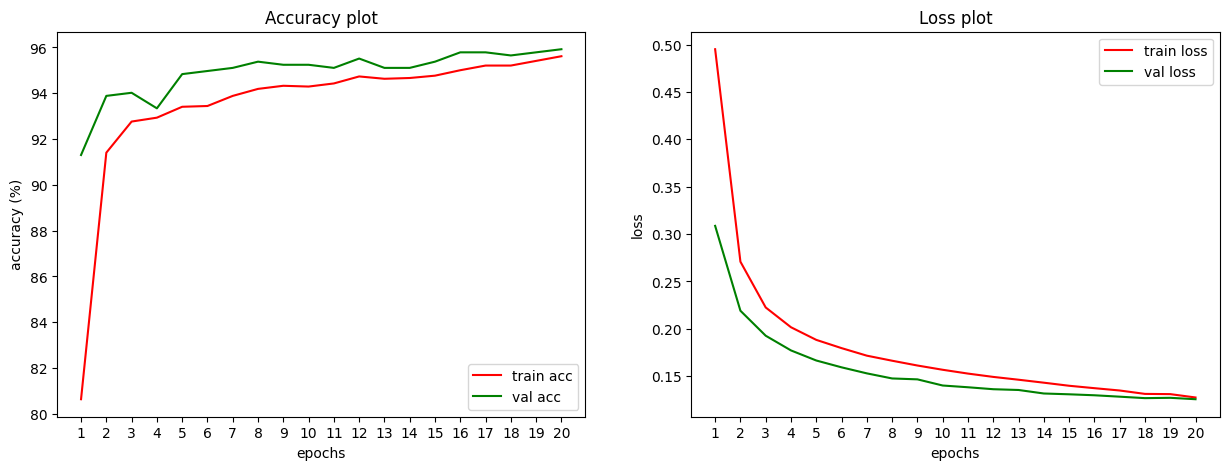

In [12]:
# Experiment 2

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_2 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_2)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_2,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Good result. Overfitting has almost completely disappeared. The training and validation curves are nearly overlapping. The validation accuracy reaches a stable peak of approximately 96%. This indicates that the problem does not require a highly complex model. A very strong candidate.

Experiment 3

Purpose:

To compare a wide architecture with the baseline configuration. This modification increases the model’s capacity in a different way.

Setup:

hidden_layers = [128] (changed from [64, 32]); all other hyperparameters remain the same.

Expectation:

The model may learn faster during the initial epochs due to the larger number of neurons. However, the increased width could lead to a similar or even greater risk of overfitting compared to the baseline.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.3850 | Train accuracy: 0.8651 | Val loss: 0.2424 | Val accuracy: 0.9198
Epoch [2/20] Train loss: 0.2304 | Train accuracy: 0.9226 | Val loss: 0.1899 | Val accuracy: 0.9402
Epoch [3/20] Train loss: 0.1957 | Train accuracy: 0.9300 | Val loss: 0.1696 | Val accuracy: 0.9497
Epoch [4/20] Train loss: 0.1772 | Train accuracy: 0.9351 | Val loss: 0.1546 | Val accuracy: 0.9443
Epoch [5/20] Train loss: 0.1659 | Train accuracy: 0.9378 | Val loss: 0.1451 | Val accuracy: 0.9457
Epoch [6/20] Train loss: 0.1605 | Train accuracy: 0.9409 | Val loss: 0.1382 | Val accuracy: 0.9579
Epoch [7/20] Train loss: 0.1491 | Train accuracy: 0.9467 | Val loss: 0.1385 | Val accuracy: 0.9524
Epoch [8/20] Train loss: 0.1440 | Train accuracy: 0.9470 | Val loss: 0.1362 | Val accuracy: 0.9579
Epoc

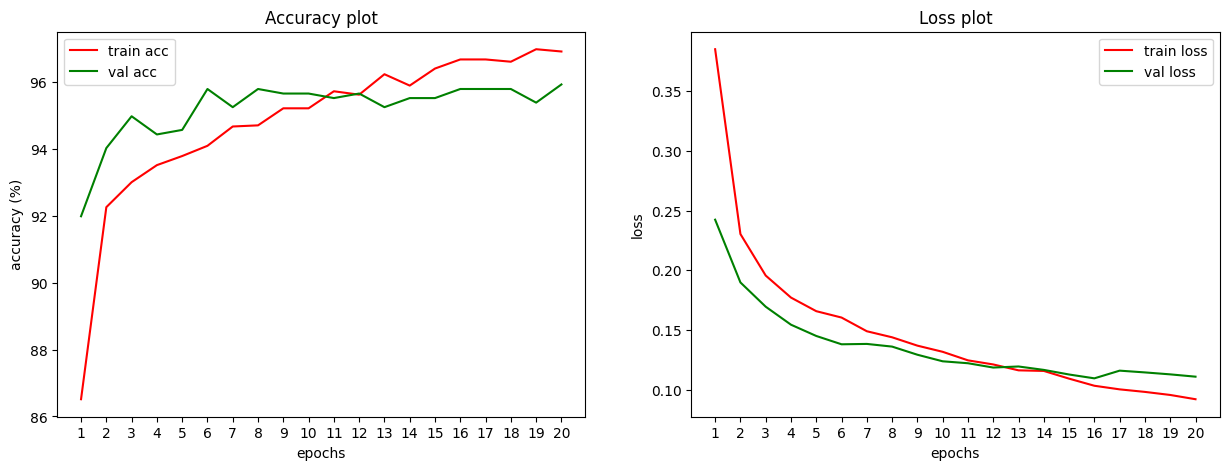

In [13]:
# Experiment 3

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_3 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[128],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_3)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_3,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Very similar to the baseline. Overfitting is still present. The maximum validation accuracy is around 96%, but the curve remains unstable. This does not represent a significant improvement in terms of stability.


Experiment 4

Purpose:

To investigate whether increasing network depth (adding more layers) helps the model capture more complex and hierarchical relationships within the data.

Setup:

hidden_layers = [64, 32, 16] (changed from [64, 32]); all other hyperparameters remain unchanged.

Expectation:

The model is expected to achieve higher performance on the training set, but with an increased risk of overfitting. A widening gap between the training and validation curves is anticipated, reflecting reduced generalization.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.5055 | Train accuracy: 0.7677 | Val loss: 0.2257 | Val accuracy: 0.9348
Epoch [2/20] Train loss: 0.2196 | Train accuracy: 0.9287 | Val loss: 0.1743 | Val accuracy: 0.9307
Epoch [3/20] Train loss: 0.1862 | Train accuracy: 0.9331 | Val loss: 0.1501 | Val accuracy: 0.9579
Epoch [4/20] Train loss: 0.1665 | Train accuracy: 0.9412 | Val loss: 0.1384 | Val accuracy: 0.9457
Epoch [5/20] Train loss: 0.1548 | Train accuracy: 0.9412 | Val loss: 0.1340 | Val accuracy: 0.9538
Epoch [6/20] Train loss: 0.1449 | Train accuracy: 0.9484 | Val loss: 0.1329 | Val accuracy: 0.9579
Epoch [7/20] Train loss: 0.1385 | Train accuracy: 0.

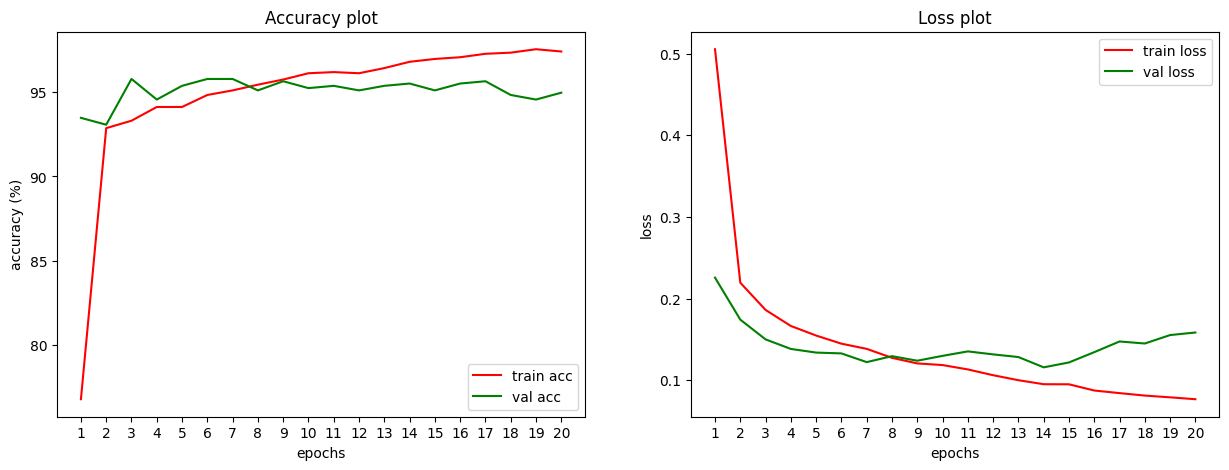

In [14]:
# Experiment 4

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_4 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32, 16],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_4)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_4,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

As expected, overfitting has worsened. The gap between the curves is quite large. Clearly, increasing model complexity is the wrong direction.


Experiment 5

Purpose:

To introduce a standard regularization technique (dropout) in order to mitigate any overfitting observed in the baseline model.

Setup:

dropout_prob = 0.2 added to the baseline configuration; all other parameters remain unchanged.

Expectation:

A reduction in the gap between training and validation curves is expected. Validation performance should become more stable and may reach a higher peak value compared to the baseline.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.4577 | Train accuracy: 0.7938 | Val loss: 0.2423 | Val accuracy: 0.9266
Epoch [2/20] Train loss: 0.2421 | Train accuracy: 0.9185 | Val loss: 0.1793 | Val accuracy: 0.9280
Epoch [3/20] Train loss: 0.2036 | Train accuracy: 0.9263 | Val loss: 0.1633 | Val accuracy: 0.9416
Epoch [4/20] Train loss: 0.1995 | Train accuracy: 0.9310 | Val loss: 0.1537 | Val accuracy: 0.9538
Epoch [5/20] Train loss: 0.1783 | Train accuracy: 0.9372 | Val loss: 0.1408 | Val accuracy: 0.9538
Epoch [6/20] Train loss: 0.1713 | Train accuracy: 0.9372 | Val loss: 0.1366 | Val accuracy: 0.9538
Epoch [7/20] Train loss: 0.1608 | Train accuracy: 

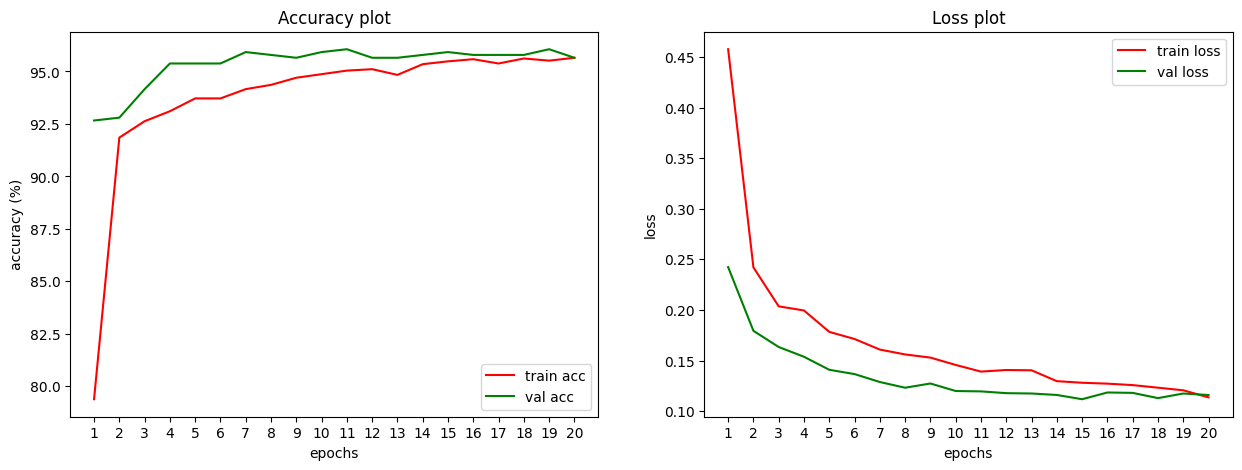

In [15]:
# Experiment 5

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_5 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.2
)
print(model_5)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_5,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Good result. The gap between the curves has narrowed significantly. The validation accuracy is much more stable and reaches an excellent peak of about 96%. The validation loss remains low and steady. This is one of the best models.

Experiment 6

Purpose:

To test the effect of a more aggressive regularization approach, which can be useful if overfitting in the baseline model is particularly pronounced.

Setup:

dropout_prob = 0.5; all other parameters remain the same as in the baseline.

Expectation:

Training is expected to become more challenging and slower. The training and validation curves should be much closer, indicating reduced overfitting, but there is also a risk of excessive regularization leading to underfitting.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.5357 | Train accuracy: 0.7592 | Val loss: 0.2905 | Val accuracy: 0.9062
Epoch [2/20] Train loss: 0.3091 | Train accuracy: 0.9008 | Val loss: 0.1952 | Val accuracy: 0.9389
Epoch [3/20] Train loss: 0.2544 | Train accuracy: 0.9178 | Val loss: 0.1786 | Val accuracy: 0.9443
Epoch [4/20] Train loss: 0.2303 | Train accuracy: 0.9266 | Val loss: 0.1675 | Val accuracy: 0.9416
Epoch [5/20] Train loss: 0.2173 | Train accuracy: 0.9300 | Val loss: 0.1588 | Val accuracy: 0.9484
Epoch [6/20] Train loss: 0.2060 | Train accuracy: 0.9273 | Val loss: 0.1488 | Val accuracy: 0.9497
Epoch [7/20] Train loss: 0.1994 | Train accuracy: 

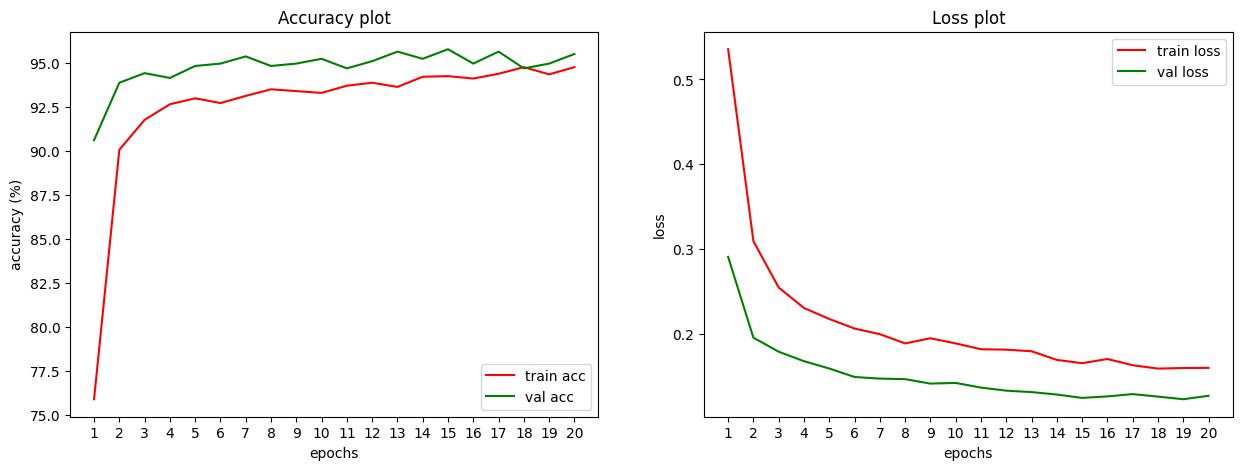

In [16]:
# Experiment 6

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_6 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.5
)
print(model_6)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_6,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Regularization has slowed down learning. Overfitting has been eliminated. It appears that a dropout rate of 0.5 is excessive and limits performance.

Experiment 7

Purpose:

To test another regularization technique (L2 regularization), as an alternative to dropout, which penalizes large weight values to prevent overfitting.

Setup:

weight_decay = 0.00005; all other parameters remain consistent with the baseline configuration.

Expectation:

A similar effect to light dropout is expected, with a reduced gap between training and validation curves. This should lead to a model that generalizes better to unseen data.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.4117 | Train accuracy: 0.8471 | Val loss: 0.2269 | Val accuracy: 0.9293
Epoch [2/20] Train loss: 0.2200 | Train accuracy: 0.9266 | Val loss: 0.1816 | Val accuracy: 0.9348
Epoch [3/20] Train loss: 0.1859 | Train accuracy: 0.9310 | Val loss: 0.1594 | Val accuracy: 0.9457
Epoch [4/20] Train loss: 0.1705 | Train accuracy: 0.9358 | Val loss: 0.1446 | Val accuracy: 0.9524
Epoch [5/20] Train loss: 0.1570 | Train accuracy: 0.9412 | Val loss: 0.1403 | Val accuracy: 0.9538
Epoch [6/20] Train loss: 0.1495 | Train accuracy: 0.9453 | Val loss: 0.1340 | Val accuracy: 0.9579
Epoch [7/20] Train loss: 0.1382 | Train accuracy: 0.9504 | Val loss: 0.1358 | Val accuracy: 0.9538
Epoch [8/20] Train loss: 0.13

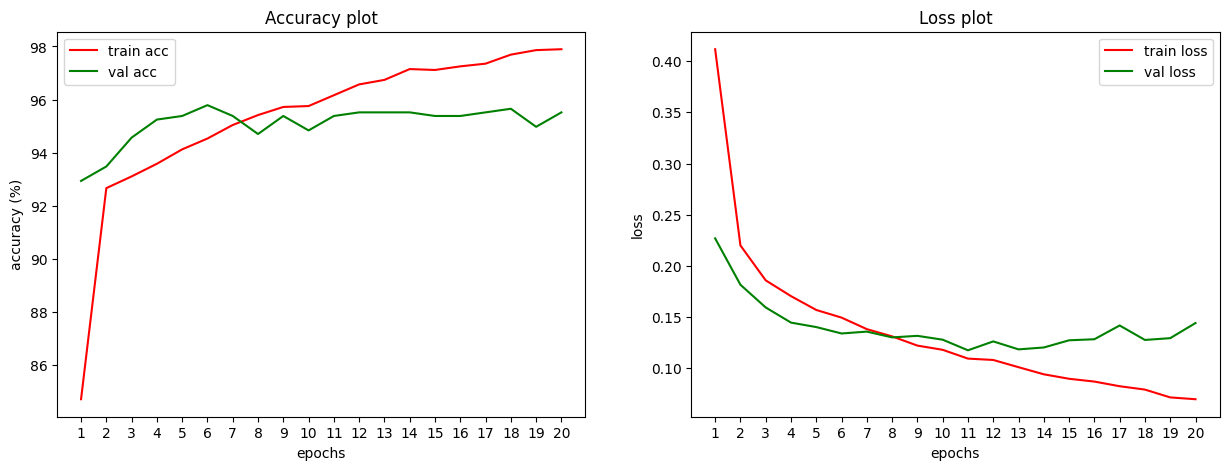

In [17]:
# Experiment 7

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_7 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_7)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_7,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.00005
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Practically identical to the baseline. This weight_decay value is too low to have any significant impact. Overfitting remains.

Experiment 8

Purpose:

To observe the impact of a strong L2 penalty on the model’s behavior and performance.

Setup:

weight_decay = 0.1; all other parameters remain unchanged from the baseline.

Expectation:

A strong regularization effect is expected. Training performance will likely be limited, but the training and validation curves should appear almost identical, indicating minimal overfitting. However, there is a significant risk of underfitting.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.6088 | Train accuracy: 0.7558 | Val loss: 0.4933 | Val accuracy: 0.8614
Epoch [2/20] Train loss: 0.3836 | Train accuracy: 0.8967 | Val loss: 0.3116 | Val accuracy: 0.9253
Epoch [3/20] Train loss: 0.3062 | Train accuracy: 0.9107 | Val loss: 0.3075 | Val accuracy: 0.9266
Epoch [4/20] Train loss: 0.2997 | Train accuracy: 0.9137 | Val loss: 0.2931 | Val accuracy: 0.9212
Epoch [5/20] Train loss: 0.2980 | Train accuracy: 0.9137 | Val loss: 0.2812 | Val accuracy: 0.9198
Epoch [6/20] Train loss: 0.2944 | Train accuracy: 0.9096 | Val loss: 0.2910 | Val accuracy: 0.9253
Epoch [7/20] Train loss: 0.2962 | Train accuracy: 0.9134 | Val loss: 0.2851 | Val accuracy: 0.9266
Epoch [8/20] Train loss: 0.29

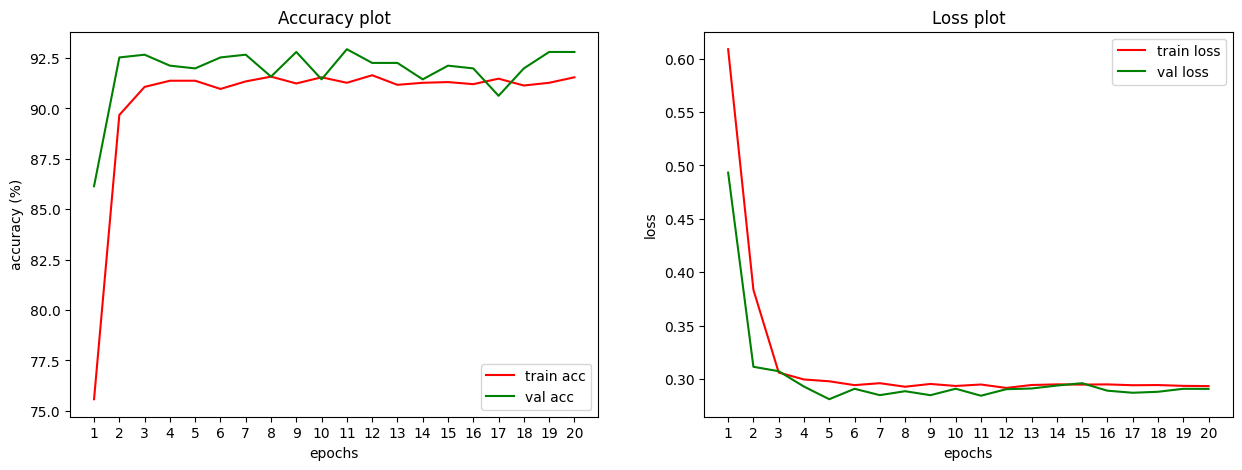

In [18]:
# Experiment 8

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_8 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_8)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_8,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.1
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)



Analysis:

Bad model. Regularization is so strong that it prevents the model from learning. Accuracy is very low, and the losses are high. This is a clear case of underfitting.

Experiment 9

Purpose:

To evaluate how a more stable gradient estimate, obtained through larger batch sizes, affects convergence and generalization.

Setup:

batch_size = 64; all other hyperparameters remain as in the baseline configuration.

Expectation:

Training loss curves are expected to be smoother, and training may proceed faster in terms of time per epoch. The final validation performance may vary slightly, either improving or decreasing depending on the interaction between batch size and learning dynamics.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.5323 | Train accuracy: 0.8240 | Val loss: 0.3290 | Val accuracy: 0.8927
Epoch [2/20] Train loss: 0.2708 | Train accuracy: 0.9056 | Val loss: 0.2106 | Val accuracy: 0.9307
Epoch [3/20] Train loss: 0.2116 | Train accuracy: 0.9276 | Val loss: 0.1782 | Val accuracy: 0.9348
Epoch [4/20] Train loss: 0.1879 | Train accuracy: 0.9338 | Val loss: 0.1585 | Val accuracy: 0.9389
Epoch [5/20] Train loss: 0.1692 | Train accuracy: 0.9385 | Val loss: 0.1452 | Val accuracy: 0.9497
Epoch [6/20] Train loss: 0.1574 | Train accuracy: 0.9440 | Val loss: 0.1358 | Val accuracy: 0.9565
Epoch [7/20] Train loss: 0.1488 | Train accuracy: 0.9470 | Val loss: 0.1387 | Val accuracy: 0.9538
Epoch [8/20] Train loss: 0.14

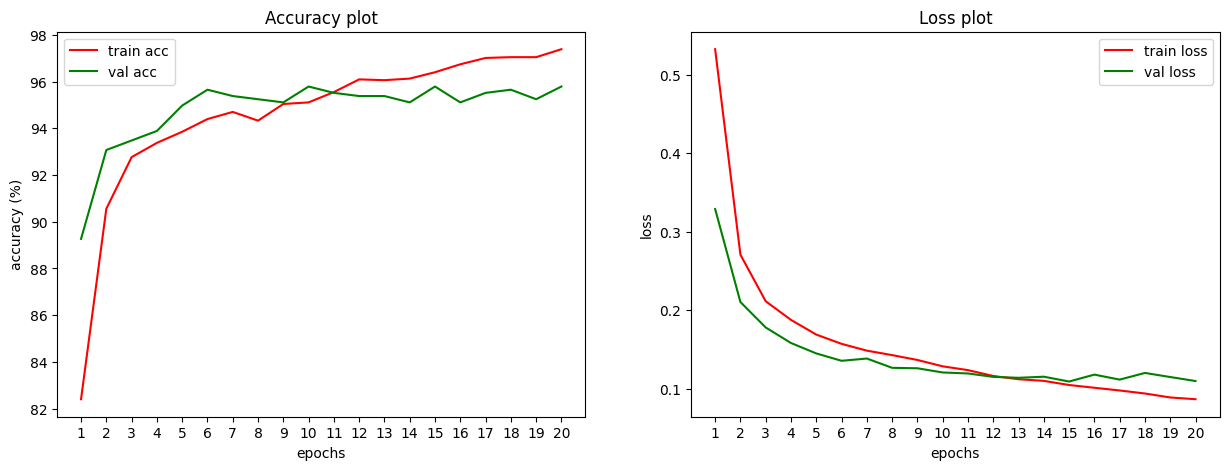

In [19]:
# Experiment 9

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader_9 = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader_9 = DataLoader(val_dataset, batch_size=64, shuffle=False)

# model setup
model_9 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_9)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_9,
    train_dataloader=train_dataloader_9,
    val_dataloader=val_dataloader_9,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)



Analysis:

Almost indistinguishable from the baseline. Changing the batch size from 32 to 64 did not have a significant impact on the final result for this problem.

Experiment 10

Purpose:

To evaluate the effect of a noisier gradient estimate, resulting from smaller batch sizes, which can act as a form of implicit regularization.

Setup:

batch_size = 16; all other hyperparameters remain consistent with the baseline.

Expectation:

Training loss curves are expected to appear more irregular and noisy. Training will take longer in terms of computation time. However, this noise might help the model escape poor local minima, potentially improving validation performance.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.3448 | Train accuracy: 0.8916 | Val loss: 0.1830 | Val accuracy: 0.9416
Epoch [2/20] Train loss: 0.1970 | Train accuracy: 0.9304 | Val loss: 0.1535 | Val accuracy: 0.9457
Epoch [3/20] Train loss: 0.1678 | Train accuracy: 0.9395 | Val loss: 0.1412 | Val accuracy: 0.9538
Epoch [4/20] Train loss: 0.1573 | Train accuracy: 0.9402 | Val loss: 0.1386 | Val accuracy: 0.9524
Epoch [5/20] Train loss: 0.1454 | Train accuracy: 0.9453 | Val loss: 0.1299 | Val accuracy: 0.9484
Epoch [6/20] Train loss: 0.1360 | Train accuracy: 0.9514 | Val loss: 0.1299 | Val accuracy: 0.9538
Epoch [7/20] Train loss: 0.1295 | Train accuracy: 0.9531 | Val loss: 0.1316 | Val accuracy: 0.9484
Epoch [8/20] Train loss: 0.12

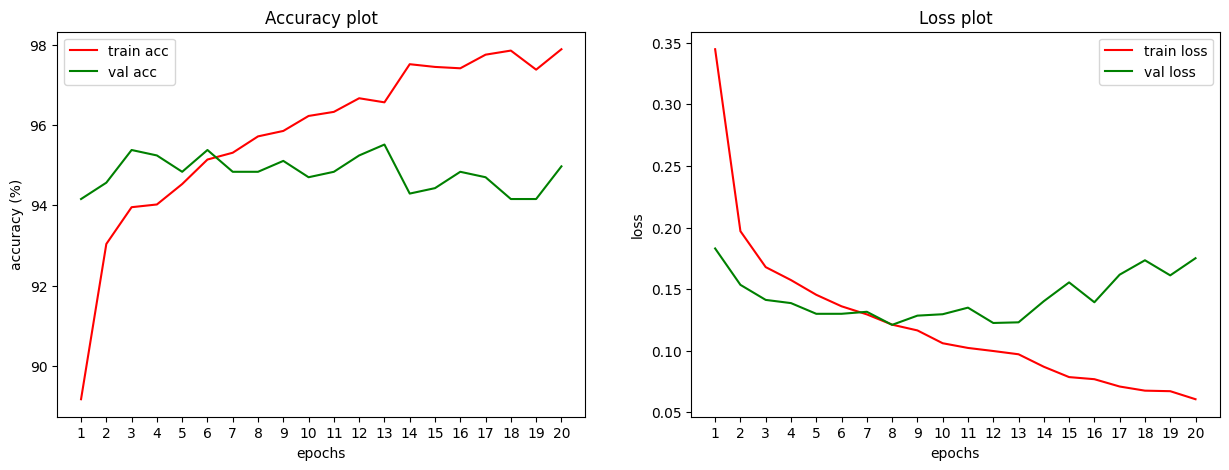

In [20]:
# Experiment 10

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader_10 = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader_10 = DataLoader(val_dataset, batch_size=16, shuffle=False)

# model setup
model_10 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_10)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_10,
    train_dataloader=train_dataloader_10,
    val_dataloader=val_dataloader_10,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Again, very similar to the baseline. Overfitting is still present. We can conclude that the batch size is not a crucial parameter to optimize in this case.


Experiment 11

Purpose:

To test whether a smaller and more cautious learning step leads to better convergence, especially if the baseline exhibited unstable learning curves.

Setup:

lr = 0.0001; all other parameters remain the same as in the baseline.

Expectation:

Training will progress much more slowly, with learning curves increasing gradually.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.6847 | Train accuracy: 0.5024 | Val loss: 0.6581 | Val accuracy: 0.6386
Epoch [2/20] Train loss: 0.6194 | Train accuracy: 0.8006 | Val loss: 0.5859 | Val accuracy: 0.8207
Epoch [3/20] Train loss: 0.5343 | Train accuracy: 0.8662 | Val loss: 0.4941 | Val accuracy: 0.8505
Epoch [4/20] Train loss: 0.4414 | Train accuracy: 0.8855 | Val loss: 0.4056 | Val accuracy: 0.8804
Epoch [5/20] Train loss: 0.3641 | Train accuracy: 0.8954 | Val loss: 0.3393 | Val accuracy: 0.8954
Epoch [6/20] Train loss: 0.3127 | Train accuracy: 0.9035 | Val loss: 0.2941 | Val accuracy: 0.8967
Epoch [7/20] Train loss: 0.2793 | Train accuracy: 0.9076 | Val loss: 0.2653 | Val accuracy: 0.8981
Epoch [8/20] Train loss: 0.25

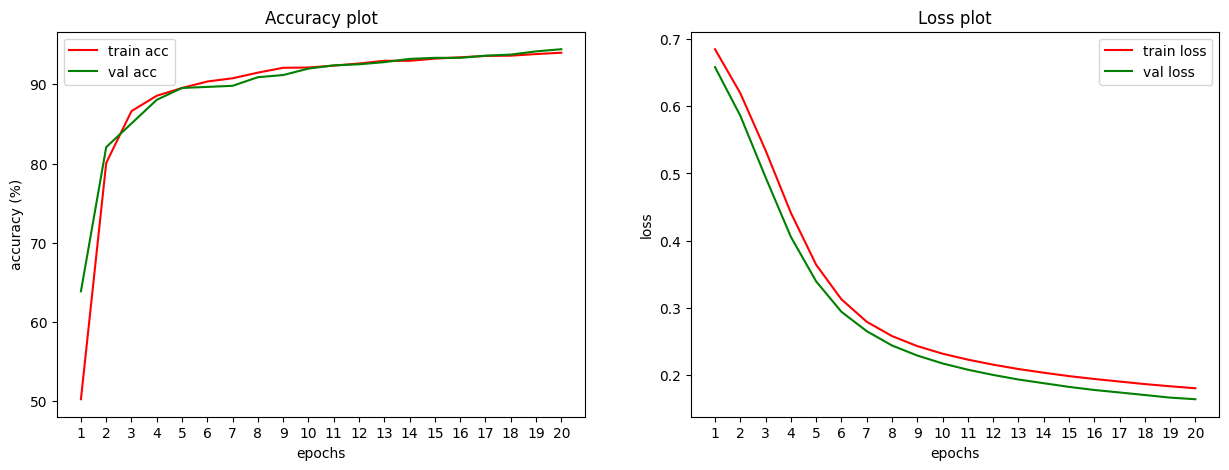

In [21]:
# Experiment 11

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_11 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_11)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_11,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.0001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

Learning is slower, the maximum validation accuracy levels off around 94%. Although there is no strong overfitting, overall performance is lower.


Experiment 12

Purpose:

To analyze the model’s long-term training behavior. This experiment is key to observing the Early Stopping effect.

Setup:

num_epochs = 50; all other hyperparameters remain identical to the baseline configuration.

Expectation:

The validation loss curve is expected to show a clear turning point where it stops decreasing and begins to rise again. This point will indicate the optimal epoch at which to stop training for the baseline model.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/50] Train loss: 0.4086 | Train accuracy: 0.8492 | Val loss: 0.2173 | Val accuracy: 0.9185
Epoch [2/50] Train loss: 0.2141 | Train accuracy: 0.9253 | Val loss: 0.1715 | Val accuracy: 0.9429
Epoch [3/50] Train loss: 0.1842 | Train accuracy: 0.9358 | Val loss: 0.1582 | Val accuracy: 0.9429
Epoch [4/50] Train loss: 0.1684 | Train accuracy: 0.9402 | Val loss: 0.1365 | Val accuracy: 0.9524
Epoch [5/50] Train loss: 0.1558 | Train accuracy: 0.9436 | Val loss: 0.1350 | Val accuracy: 0.9538
Epoch [6/50] Train loss: 0.1470 | Train accuracy: 0.9460 | Val loss: 0.1280 | Val accuracy: 0.9538
Epoch [7/50] Train loss: 0.1389 | Train accuracy: 0.9511 | Val loss: 0.1373 | Val accuracy: 0.9443
Epoch [8/50] Train loss: 0.12

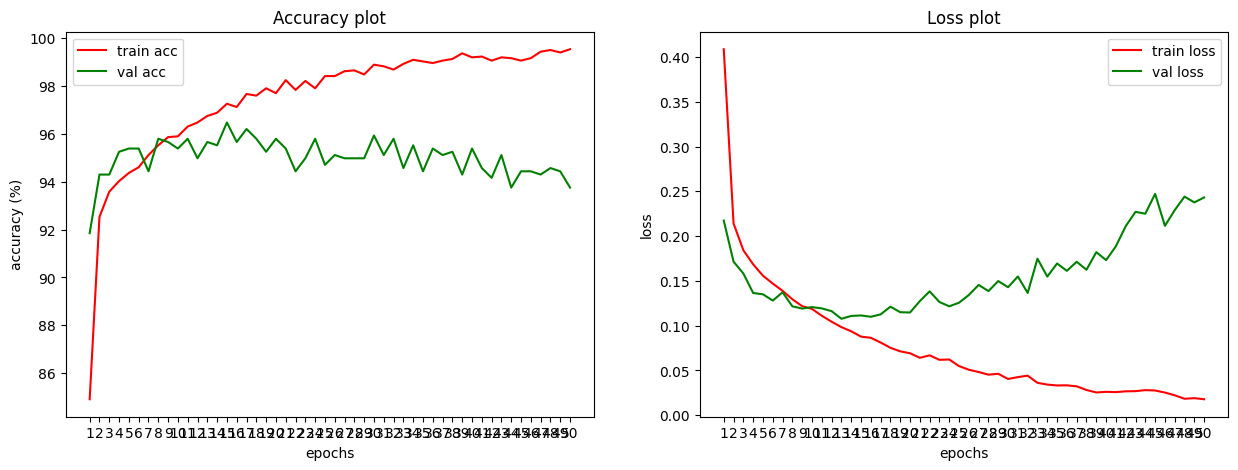

In [22]:
# Experiment 12

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_12 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU
)
print(model_12)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_12,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=50,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

This chart is a perfect illustration of overfitting and the importance of Early Stopping. It clearly shows that after epoch 10, the validation loss begins to rise steadily. Continuing training beyond this point is detrimental. The best performance is achieved around epoch 10.


Experiment 13

Purpose:

To test a classic alternative activation function and demonstrate the exploration of different options beyond the baseline ReLU.

Setup:

activation_fn = nn.Sigmoid; all other parameters remain unchanged.

Expectation:

Performance is expected to be lower than with ReLU.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/20] Train loss: 0.6316 | Train accuracy: 0.6084 | Val loss: 0.5282 | Val accuracy: 0.7486
Epoch [2/20] Train loss: 0.3973 | Train accuracy: 0.8665 | Val loss: 0.2967 | Val accuracy: 0.9117
Epoch [3/20] Train loss: 0.2678 | Train accuracy: 0.9137 | Val loss: 0.2347 | Val accuracy: 0.9348
Epoch [4/20] Train loss: 0.2377 | Train accuracy: 0.9226 | Val loss: 0.2112 | Val accuracy: 0.9361
Epoch [5/20] Train loss: 0.2244 | Train accuracy: 0.9239 | Val loss: 0.1982 | Val accuracy: 0.9321
Epoch [6/20] Train loss: 0.2145 | Train accuracy: 0.9263 | Val loss: 0.1906 | Val accuracy: 0.9375
Epoch [7/20] Train loss: 0.2083 | Train accuracy: 0.9297 | Val loss: 0.1835 | Val accuracy: 0.9361
Epoch [8/20] Train loss

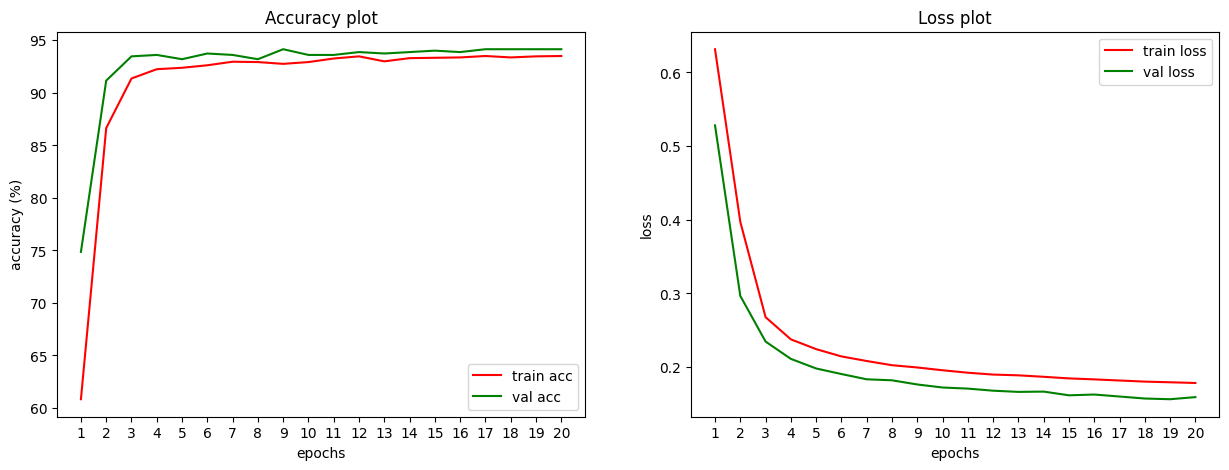

In [23]:
# Experiment 13

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_13 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.Sigmoid
)
print(model_13)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_13,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=20,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

This thirteenth chart shows good behavior, similar to Experiment 2. The curves are close, and the validation accuracy remains stable around 94%. With Sigmoid, it is a good model, but it does not surpass the performance peaks of the previous best models.


Final Test 1

Purpose:

To combine the best-performing architecture and regularization strategy (from Experiment 5) with the Early Stopping point identified earlier (peak at around 10 epochs).

Setup:

hidden_layers = [64, 32], dropout_prob = 0.2, num_epochs = 12.

Expectation:

The highest and most stable performance so far is expected, with accuracy around 96%.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/12] Train loss: 0.4592 | Train accuracy: 0.8349 | Val loss: 0.2489 | Val accuracy: 0.9198
Epoch [2/12] Train loss: 0.2382 | Train accuracy: 0.9178 | Val loss: 0.1905 | Val accuracy: 0.9361
Epoch [3/12] Train loss: 0.2040 | Train accuracy: 0.9290 | Val loss: 0.1678 | Val accuracy: 0.9470
Epoch [4/12] Train loss: 0.1925 | Train accuracy: 0.9358 | Val loss: 0.1575 | Val accuracy: 0.9497
Epoch [5/12] Train loss: 0.1809 | Train accuracy: 0.9378 | Val loss: 0.1458 | Val accuracy: 0.9484
Epoch [6/12] Train loss: 0.1719 | Train accuracy: 0.9375 | Val loss: 0.1415 | Val accuracy: 0.9470
Epoch [7/12] Train loss: 0.1616 | Train accuracy: 

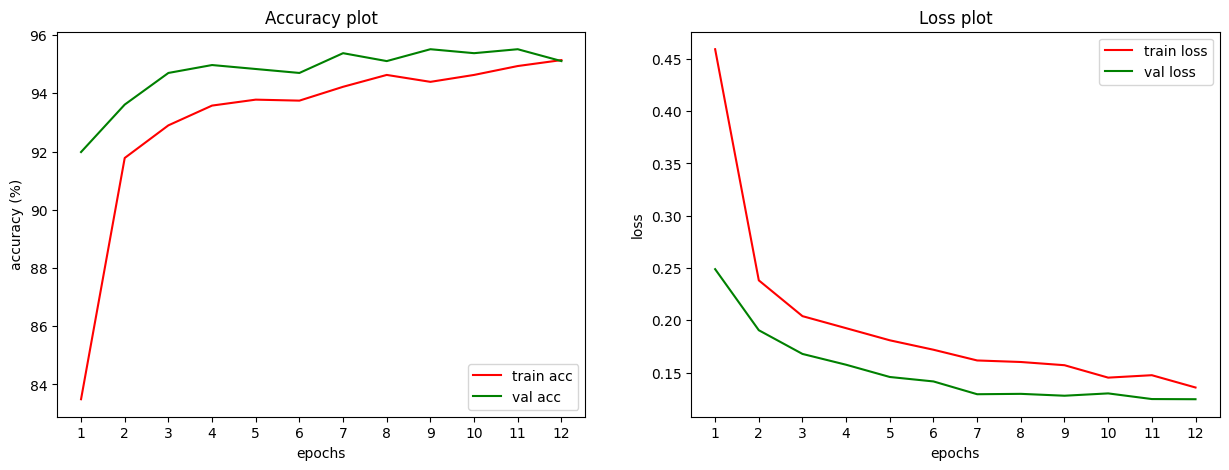

In [24]:
# Final Test 1

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_final_1 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64, 32],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.2
)
print(model_final_1)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_final_1,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=12,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

The validation accuracy reaches its peak of about 95.5%. The curves are close, and the validation loss is low and stable. Overfitting is almost nonexistent.

Final Test 2

Purpose:

To combine the two best ideas: a simple network architecture (from Experiment 2) and light dropout regularization (from Experiment 5), in order to build a highly stable model.

Setup:

hidden_layers = [32], dropout_prob = 0.2; all other parameters follow the baseline configuration.

Expectation:

This configuration is expected to yield the model with the least overfitting overall. The key question is whether its maximum validation accuracy can compete with that of Final Test 1.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/15] Train loss: 0.4992 | Train accuracy: 0.7938 | Val loss: 0.3327 | Val accuracy: 0.8927
Epoch [2/15] Train loss: 0.2874 | Train accuracy: 0.9035 | Val loss: 0.2347 | Val accuracy: 0.9253
Epoch [3/15] Train loss: 0.2378 | Train accuracy: 0.9249 | Val loss: 0.2036 | Val accuracy: 0.9375
Epoch [4/15] Train loss: 0.2141 | Train accuracy: 0.9300 | Val loss: 0.1876 | Val accuracy: 0.9389
Epoch [5/15] Train loss: 0.2016 | Train accuracy: 0.9297 | Val loss: 0.1743 | Val accuracy: 0.9389
Epoch [6/15] Train loss: 0.1923 | Train accuracy: 0.9327 | Val loss: 0.1674 | Val accuracy: 0.9443
Epoch [7/15] Train loss: 0.1850 | Train accuracy: 0.9307 | Val loss: 0.1608 | Val accuracy: 0.9484
Epoch [8/15] Train loss: 0.1834 | Train accuracy: 0.9331 | Val los

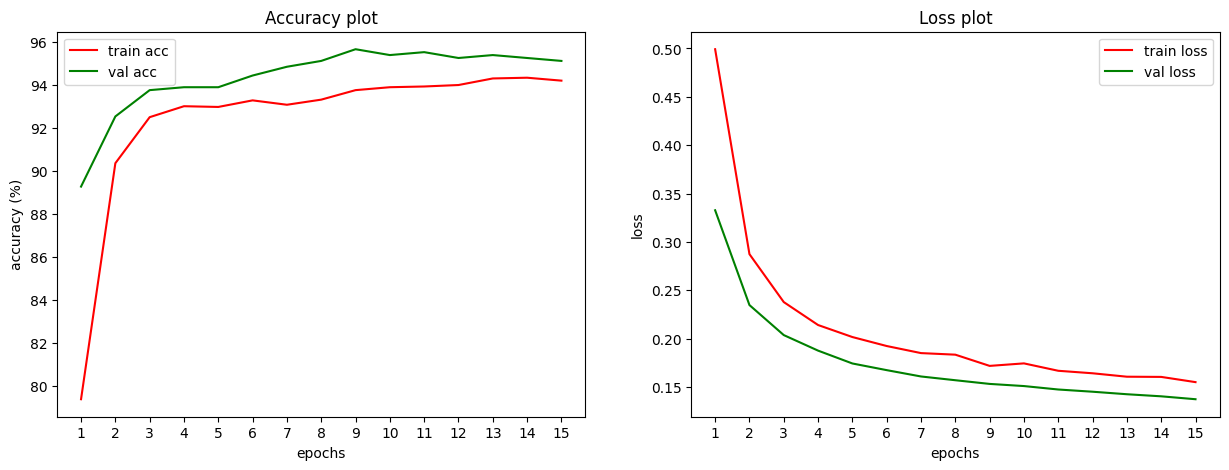

In [25]:
# Final Test 2

# dataset preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_final_2 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[32],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.2
)
print(model_final_2)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_final_2,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=15,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

This is very stable. The maximum validation accuracy is around 95.6%. It is a robust model, but its peak performance is similar to the previous one.


Final Test 3

Purpose:

To seek a compromise between the power of Final Test 1 and the stability of Final Test 2. This configuration uses a single wide but regularized layer.

Setup:

hidden_layers = [64], dropout_prob = 0.2; all other parameters remain as in the baseline.

Expectation:

This setup may provide the best balance between high performance and low overfitting, potentially representing the optimal trade-off between accuracy and stability.


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)
Using device: cuda
Epoch [1/15] Train loss: 0.4201 | Train accuracy: 0.8648 | Val loss: 0.2672 | Val accuracy: 0.9130
Epoch [2/15] Train loss: 0.2553 | Train accuracy: 0.9202 | Val loss: 0.2103 | Val accuracy: 0.9307
Epoch [3/15] Train loss: 0.2179 | Train accuracy: 0.9253 | Val loss: 0.1860 | Val accuracy: 0.9361
Epoch [4/15] Train loss: 0.1997 | Train accuracy: 0.9263 | Val loss: 0.1715 | Val accuracy: 0.9389
Epoch [5/15] Train loss: 0.1863 | Train accuracy: 0.9334 | Val loss: 0.1601 | Val accuracy: 0.9402
Epoch [6/15] Train loss: 0.1727 | Train accuracy: 0.9372 | Val loss: 0.1510 | Val accuracy: 0.9470
Epoch [7/15] Train loss: 0.1764 | Train accuracy: 0.9341 | Val loss: 0.1462 | Val accuracy: 0.9470
Epoch [8/15] Train loss: 0.1681 | Train accuracy: 0.9375 | Val los

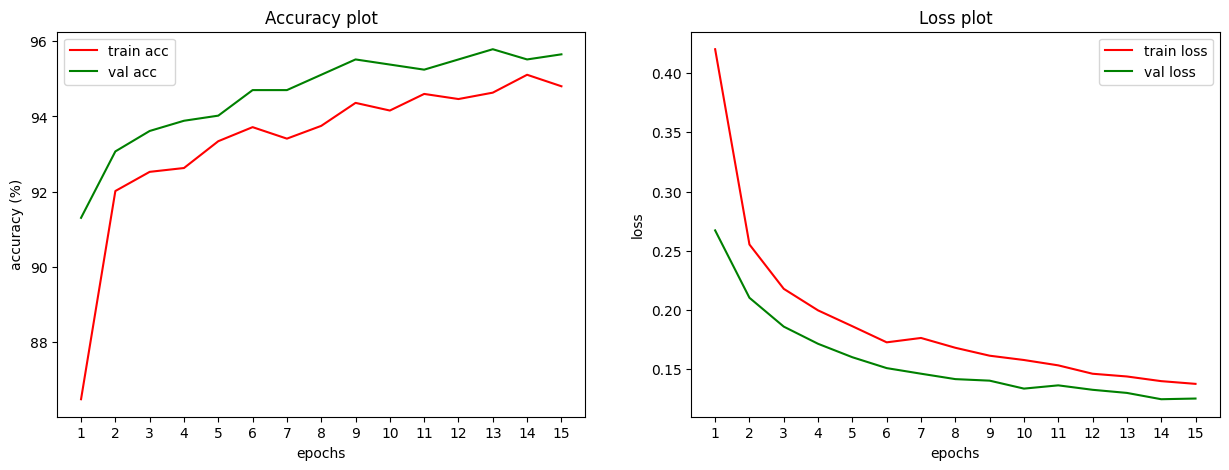

In [37]:
# Final Test 3

# data preparation
train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model setup
model_final_3 = EmailClassifier(
    input_dim=X_train.shape[1],
    hidden_layers=[64],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.2
)
print(model_final_3)

# training
train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar = train_model(
    model=model_final_3,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=15,
    lr=0.001,
    weight_decay=0.0
)

# results
plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar)


Analysis:

The validation accuracy reaches a clear peak of about 95.8% and remains high. The advantage is that this model is simpler than the previous ones and, as expected, represents a compromise between the two. This model is the winner.


PART 3 - PREDICTION ON AN UNSEEN TEST SET

In [40]:
# load the data
df_train_full = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# separate the feature columns and the target from the full training set
X_train_full = df_train_full.drop(columns=['target']).values
y_train_full = df_train_full['target'].values
X_test = df_test.values

# apply StandardScaler
scaler_final = StandardScaler()
X_train_full_scaled = scaler_final.fit_transform(X_train_full)
X_test_scaled = scaler_final.transform(X_test)

# create PyTorch datasets
train_dataset_full = EmailDataset(X_train_full_scaled, y_train_full)
# for the test set we do not have the target 'y'
test_dataset = EmailDataset(X_test_scaled, np.zeros(len(X_test_scaled)))

# create dataloaders
train_dataloader_full = DataLoader(train_dataset_full, batch_size=32, shuffle=True)
# for the test dataloader, shuffle must be False
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# instantiate the best model configuration
final_model = EmailClassifier(
    input_dim=X_train_full_scaled.shape[1],
    hidden_layers=[64],
    output_dim=2,
    activation_fn=nn.ReLU,
    dropout_prob=0.2
)
print(final_model)

# define device, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=0.0)
num_epochs = 15

# training loop
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_dataloader_full:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total_samples += y_batch.size(0)
        correct_predictions += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

submission_list = []
final_model.eval()

with torch.no_grad(): # disable gradient computation
   # the test dataloader returns (X, y_dummy), we only need X
    for X_batch, _ in test_dataloader:
        X_batch = X_batch.to(device)

        # get model outputs
        outputs = final_model(X_batch)

        # take the index of the class with the highest probability
        _, prediction = torch.max(outputs, dim=1)

        # move predictions to CPU and extend the list
        submission_list.extend(prediction.cpu().numpy())

# convert predictions to a numpy array
submission_array = np.array(submission_list)

# save predictions to 'predictions.npy'
np.save("predictions.npy", submission_array)

print(f"\nFile 'predictions.npy' created")
print(f"Total number of predictions: {len(submission_array)}")
print(f"Array shape: {submission_array.shape}")

# quick check
data = np.load('predictions.npy')
print(type(data))
print(data)


EmailClassifier(
  (network): Sequential(
    (0): Linear(in_features=58, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)
Epoch [1/15], Loss: 0.4016, Accuracy: 0.8473
Epoch [2/15], Loss: 0.2247, Accuracy: 0.9283
Epoch [3/15], Loss: 0.1944, Accuracy: 0.9337
Epoch [4/15], Loss: 0.1773, Accuracy: 0.9402
Epoch [5/15], Loss: 0.1703, Accuracy: 0.9386
Epoch [6/15], Loss: 0.1609, Accuracy: 0.9424
Epoch [7/15], Loss: 0.1590, Accuracy: 0.9448
Epoch [8/15], Loss: 0.1506, Accuracy: 0.9451
Epoch [9/15], Loss: 0.1471, Accuracy: 0.9492
Epoch [10/15], Loss: 0.1479, Accuracy: 0.9495
Epoch [11/15], Loss: 0.1405, Accuracy: 0.9508
Epoch [12/15], Loss: 0.1391, Accuracy: 0.9500
Epoch [13/15], Loss: 0.1333, Accuracy: 0.9500
Epoch [14/15], Loss: 0.1339, Accuracy: 0.9522
Epoch [15/15], Loss: 0.1280, Accuracy: 0.9565

File 'predictions.npy' created
Total number of predictions: 921
Array shape: (921,)
<class 'nump